In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import cv2
import os
import requests
import gzip
from PIL import Image
import random

Import Data

In [ ]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

# source: https://numpy.org/numpy-tutorials/content/tutorial-deep-learning-on-mnist.html


data_dir = "/content/data"
os.makedirs(data_dir, exist_ok=True)
base_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
for fname in data_sources.values():
  fpath = os.path.join(data_dir, fname)
  if not os.path.exists(fpath):
    print("Downloading file: " + fname)
    resp = requests.get(base_url + fname, stream=True)
    resp.raise_for_status()  # Ensure download was succesful
    with open(fpath, "wb") as fh:
      for chunk in resp.iter_content(chunk_size=128):
        fh.write(chunk)

In [ ]:
mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

Visualize data

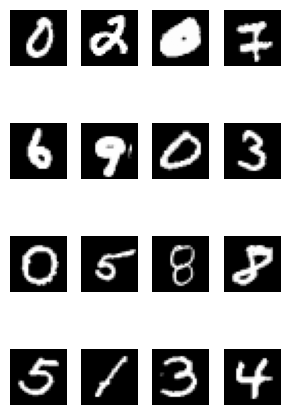

In [ ]:
def show_images(x_data):
  fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(3,5))
  for ax in axes.flatten():
    random_integer = random.randint(0, x_data.shape[0] - 1)
    img = x_data[random_integer, :].reshape(28,28)
    ax.axis('off')
    ax.imshow(img, cmap='gray')
  plt.tight_layout()
  plt.show()

show_images(x_train)

Update data

In [ ]:
# modify data such that we change labels to 0 to indicate even and 1 to indicate odd
y_train_oddeven = y_train % 2
y_test_oddeven = y_test % 2

print(y_train[0:20])
print(y_train_oddeven[0:20])
# check if proportions of odd and even are somewhat close
print(np.count_nonzero(y_train_oddeven == 1) / np.count_nonzero(y_train_oddeven == 0))
print(np.count_nonzero(y_test_oddeven == 1) / np.count_nonzero(y_test_oddeven == 0))

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1]
1.0344500203445002
1.0300446609825415


Implement logistic regression

In [ ]:
x_train_normalized = x_train/255.0
x_test_normalized = x_test/255.0

x_train = x_train_normalized.transpose()
x_test = x_test_normalized.transpose()
y_train = y_train_oddeven.reshape(1, y_train_oddeven.shape[0])
y_test = y_test_oddeven.reshape(1, y_test_oddeven.shape[0])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

dim_train = x_train.shape[1]
dim_test = x_test.shape[1]
print(dim_train)
print(dim_test)

def sigmoid(z):
  return 1.0/(1.0 + np.exp(-z))

def initialize(dim):
  limit = np.sqrt(6.0/(dim+1))
  w = np.random.uniform(low=-limit, high=limit, size=(dim,1))
  b = 0
  return w,b

def backprop(w,b,x,y):
  m = x.shape[1]
  z = np.dot(w.T,x) + b
  output = sigmoid(z)
  cost = (-1.0/m)*(np.sum(y*np.log(output) + (1-y)*np.log(1-output)))
  dw = (1.0/m)*np.dot(x, (output-y).T)
  db = (1.0/m)*np.sum(output-y)

  cost = np.squeeze(cost)
  grads = {"dw" : dw, "db" : db}

  return grads, cost

def optimize(w,b,x,y,num_iter, lr_rate):
  costs = []

  for i in range(num_iter):
    grads, cost = backprop(w,b,x,y)

    dw = grads["dw"]
    db = grads["db"]
    w = w - lr_rate * dw
    b = b - lr_rate * db
    if i % 100 == 0:
      print(cost)
  params = {"w" : w, "b" : b}
  return costs, params

def predict(w,b,x):
  m = x.shape[1]
  y_prediction = np.zeros((1,m))
  w = w.reshape(x.shape[0],1)
  output = sigmoid(np.dot(w.T,x) + b)
  for i in range(output.shape[1]):
    if output[:,i] > 0.5:
      y_prediction[:,i] = 1
    elif output[:,i] <= 0.5:
      y_prediction[:,i] = 0

  return y_prediction

def model(x_train, y_train, x_test, y_test, num_iter=2000, lr_rate=0.6):
  w,b = initialize(x_train.shape[0])
  costs, params = optimize(w,b,x_train,y_train, num_iter, lr_rate)
  w = params["w"]
  b = params["b"]

  y_predict_train = predict(w,b,x_train)
  y_predict_test = predict(w,b,x_test)
  print(y_predict_train.shape)
  train_acc = 100.0 * (y_predict_train == y_train).sum() / y_train.shape[1]
  test_acc = 100.0 * (y_predict_test == y_test).sum() / y_test.shape[1]

  print("training accuracy: ", train_acc)
  print("test accuracy: ", test_acc)


model(x_train, y_train, x_test, y_test)

(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)
60000
10000
0.7437380116715948
0.3347412602159451
0.29832235026297926
0.2806641367191943
0.2705534319563934
0.26620031117018056
0.2642577901416236
0.2627883742376904
0.26160620364777265
0.26062863273695974
0.2598026461171286
0.2590926471026506
0.258473801504007
0.2579282053405984
0.25744258081646965
0.25700683789955725
0.2566131456643427
0.2562553144024458
0.2559283731915334
0.2556282739399842
(1, 60000)
training accuracy:  90.03
test accuracy:  90.01
